In [85]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import time

In [38]:
# NOTE: THIS CELL TAKES 25 MIN TO RUN (I had to add delays to avoid reaching my API rate limit)
# Preliminary: Fetch relevant blocks
# We wish to construct a time series with a bi-monthly granularity over a 2022-Present. To fetch data at each of these snapshots, we need
# the block ID of an ethereum block at each of these points, to give the global state of our desired liquidity pools at each of these snapshots

# Here, I will fetch block IDs with daily granularity (~1000 data points), and we can later choose which blocks to 
# include in our final time series (dataframe with timestamp -> ethereum block ID).
# Note that we need to use Unix/Epoch time when making our query

# Use Etherscan API. Can cross-check results using Etherscan block/time converter

dates = pd.date_range(start="2022-01-01", end=pd.Timestamp.today(), freq="D")
dates_array = dates.to_numpy() # all dates from 01/01/2022 - 11/29/2025
unix_times = dates.astype(int) // 10**9 # convert to unix time

etherscan_api_key = "H7DU57VXVFGCFWH2Z5B1MV889VR1K7677E"
block_to_date_df = pd.DataFrame(columns=['Datetime', 'Ethereum Block Number'])

for i in range(len(unix_times)):
    timestamp = unix_times[i]
    url = (f"https://api.etherscan.io/v2/api?chainid=1&module=block&action=getblocknobytime&timestamp={timestamp}&closest=before&apikey={etherscan_api_key}")
    response = requests.get(url).json()
    block_number = int(response["result"])
    block_to_date_df.loc[len(block_to_date_df)] = [dates_array[i], block_number]
    time.sleep(1) # Add a one second delay to avoid reaching rate limit for API

block_to_date_df.head(20)

,Datetime,Ethereum Block Number
0,2022-01-01,13916165
1,2022-01-02,13922671
2,2022-01-03,13929166
3,2022-01-04,13935627
4,2022-01-05,13942121
5,2022-01-06,13948581
6,2022-01-07,13954973
7,2022-01-08,13961396
8,2022-01-09,13967921
9,2022-01-10,13974426


In [39]:
block_to_date_df.to_csv("datetime_to_eth_block_number.csv")

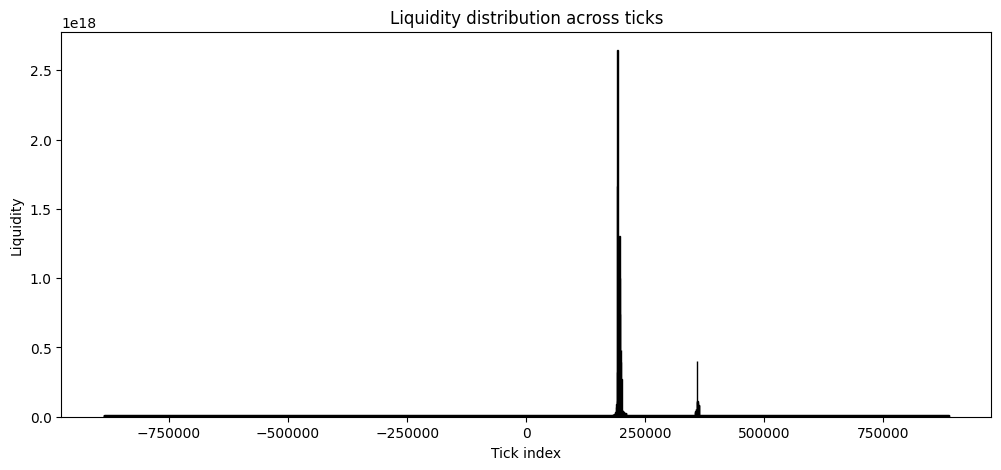

In [90]:
# Liquidity pool 1: ETH/USDC (Example of Workflow)
# i. Get liquidity pool ID using Uniswap API
# We get the address of ETH, USDC using Etherscan.io

# ii. Get a snapshot of current liquidity distribution across ticks (EDA)
# Get all current positions
uniswap_api_key = "2b45e1f034a61c2f41bf4bcd6731335a"
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"
url = f"https://gateway.thegraph.com/api/{uniswap_api_key}/subgraphs/id/{subgraph_id}"

query = """
query GetPositions($poolId: String!) {
  positions(
    where: { pool: $poolId, liquidity_gt: 0 }  # Only positions with liquidity
    first: 1000  # adjust if you expect more than 1000 positions
  ) {
    liquidity
    depositedToken0
    depositedToken1
    withdrawnToken0
    withdrawnToken1
    tickLower {
      tickIdx
    }
    tickUpper {
      tickIdx
    }
  }
}
"""

variables = {"poolId": "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640".lower()}
response = requests.post(url, json={"query": query, "variables": variables}, headers={"Content-Type": "application/json"})
data = response.json()
# Convert to dataframe to clean up
positions_df = pd.DataFrame(columns = ['Deposited Token 0', 'Deposited Token 1', 'Total Liquidity Desposited', 'Lower Tick', 'Upper Tick', 'Withdrawn Token 0', 'Withdrawn Token 1'])
for index in range(len(data['data']['positions'])):
    positions_df.loc[len(positions_df)] = [
        data['data']['positions'][index]['depositedToken0'],
        data['data']['positions'][index]['depositedToken1'],
        data['data']['positions'][index]['liquidity'],
        data['data']['positions'][index]['tickLower']['tickIdx'],
        data['data']['positions'][index]['tickUpper']['tickIdx'],
        data['data']['positions'][index]['withdrawnToken0'],
        data['data']['positions'][index]['withdrawnToken1']
    ]
cols_to_convert = [col for col in positions_df.columns]
positions_df[cols_to_convert] = positions_df[cols_to_convert].astype(float)
positions_df.head(60)

# Note: Absolute min/max ticks: -887270, 887270
# Plot
tick_min = -887272
tick_max = 887272
bin_width = 600  # change granularity
bins = np.arange(tick_min, tick_max + bin_width, bin_width)
liquidity_per_bin = np.zeros(len(bins) - 1)

for idx, row in positions_df.iterrows():
    # Find bin indices that overlap with this position
    bin_indices = np.where(
        (bins[:-1] < row['Upper Tick']) & (bins[1:] > row['Lower Tick'])
    )[0]
    
    # Add liquidity to these bins
    liquidity_per_bin[bin_indices] += row['Total Liquidity Desposited']
# x = bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12,5))
plt.bar(bin_centers, liquidity_per_bin, width=bin_width, edgecolor='k')
plt.xlabel("Tick index")
plt.ylabel("Liquidity")
plt.title("Liquidity distribution across ticks")
plt.show()
# ii. For each of our bins [lower tick, upper tick], query the total liquidity in this range across all positions at time t 
# (see corresponding block)

# iii. Normalize data to create density plots, vectorize data 
# (1 vector = percentage of total liquidity across all positions in each range at time t. 
# Ex: [% Amt in 0-1000, % Amt in 1001-2000, % Amt in 2001+])

# vi. Cleanup

In [ ]:
# vii. Visualize (Stacked Bar Chart)

In [ ]:
# viii. Visualize (Ridge Line Plot)

In [ ]:
# ix. Visualize (Alluvial Plot)

In [19]:
# Generally in API call, you include the url (address of the server to query from), the specific query to be made, if working with
# a GraphQL query, and then format the response (requests.post().json())

# Get the ID of the top 20 most liquid pools (most trade activity -> most likely to have price slippage)
query = """
{
  pools(first: 20) {
    id
    token0 { symbol }
    token1 { symbol }
    feeTier
  }
}
"""
response = requests.post(url, json={"query": query})
data = response.json()
data

{'data': {'pools': [{'feeTier': '991399',
    'id': '0x0000b6dc3fa99f1e287a233c50edc6f1668e0ac6500c80d429f442a03449ca51',
    'token0': {'symbol': 'ETH'},
    'token1': {'symbol': 'IOST'}},
   {'feeTier': '700000',
    'id': '0x000305ccca383aaeee284804e6610b8ff9e42744ba5f3096f959bbbaed1d099c',
    'token0': {'symbol': 'IWNon'},
    'token1': {'symbol': 'USDC'}},
   {'feeTier': '240000',
    'id': '0x0003be2d3d4202dff5766085e6c00742a32ef88ebabed380ab1ec4fbb416604d',
    'token0': {'symbol': 'ETH'},
    'token1': {'symbol': 'XAR'}},
   {'feeTier': '20000',
    'id': '0x00065a5543d291419481d1e047554276f804b7c40ad90ad7ee8acd736e0de7e3',
    'token0': {'symbol': 'ETH'},
    'token1': {'symbol': 'SANCHAN'}},
   {'feeTier': '100',
    'id': '0x000713d84318dd4d1a6b9c47c7ebc842c56450bfe3c3babfc7ed5840a93c60f1',
    'token0': {'symbol': 'USDT'},
    'token1': {'symbol': 'USDT'}},
   {'feeTier': '0',
    'id': '0x0007bf35171b1c5daf926becf43b63eeca9976f8153fb70f79a7ed1093d467bc',
    'token0': {'s